In [3]:
from script.traj_to_dataframe import *
from script.inverse_design import *
import pickle

# Generate fingerprint dataframe to train

## - Convert structure to active motif by our method, and generate fingerprint with properties from active motif

#### * Fingerprint is consisted with 11 elemental properties (Atomic number, Block, Ionic radius, Common oxidation state, Electronegativity, Row, Group, Thermal conductivity, Boiling point, Melting point, First ionization energy) and the number of atoms at each site, including total 36 columns 

In [ ]:
# open CO or H binding data from GASpy
with open('/home/ahrehd0506/git/New_active_motif/data/CO_docs_slab_added.pkl', 'rb') as p_f:
    data = pickle.load(p_f)


# remove nitrdie, sulfide, hydrate and outlier from dataset
Nitride=[]
Sulfide=[]
Hydrate=[]
outliner=[]

Else_index = []
new_data=[]

for i, v in enumerate(data):
    element = v['slab_information']['atoms']['chemical_symbols']
    energy =  v['energy']
    slab_movement = v['movement_data']['max_slab_movement']
    adsorb_movement = v['movement_data']['max_adsorbate_movement']
    if (energy >= -2.3) & (energy <= 0.3) & (slab_movement <= 1.2) & (adsorb_movement <= 1.49): # outlier criteria
        outliner.append(i)
        if 'N' in element:
            Nitride.append(i)
        elif 'S' in element:
            Sulfide.append(i)
        elif 'H' in element:
            Hydrate.append(i)
        else:
            Else_index.append(i)
Del_index = Nitride+Sulfide+Hydrate

for i in Else_index:
    new_data.append(data[i])

# collect trajactory name (mpid + mongo_id) without outliers
new_slab_name = []
for i in new_data:
    name = i['mpid']+'_'+str(i['mongo_id'])
    new_slab_name.append(name)
new_slab_name.sort()

# path of folder with atom trajactory, 
# I will modify 'make_traj_to_dataframe' function to read atomic structure from data.pkl without trajctory files ASAP 
path = '/home/ahrehd0506/research/GASpy/final_CO_slab/'

# Make fingerprint as dataframe from structure ,corresponding to file names you input, in trajactory folder 
# Output Error is name list of atom occuring error because it is not suitable for our method, or due to many other reason 
df, error = make_traj_to_dataframe(new_slab_name,path)
df

# Training input data & check prediction accuracy

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd

# input binding energy to dataframe
# This process will be unnecessary once the 'make_traj_to_dataframe' function is modifed
energy_list = []
name_list =[]
data_energy = []
for i in data:
    name_list.append(str(i['mpid'])+'_'+str(i['mongo_id']))
    energy_list.append(i['energy'])
for name in df['name']:
    for index,value in enumerate(name_list):
        if name == value:
            data_energy.append(energy_list[index])
df['energy'] = data_energy

# set descriptors and target and split to train set and test set
name = df.loc[:,'name']

X = df.iloc[:,1:-1]
y = df.loc[:,'energy'].astype(np.float)

# scaling descriptors due to different ranges of properties
scalar = StandardScaler()
X = scalar.fit_transform(X.astype(np.float))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

##################################################################################################
# Find optimal Hyperparameter by Bayesian optimization 
'''
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

reg = GradientBoostingRegressor()

search_space = {
    "learning_rate": Real(0.0000001,1), 
    "n_estimators": Integer(100,5000),
    "min_samples_split": Integer(2, 30),
    "min_samples_leaf": Integer(1,30),
    "loss": Categorical(['ls', 'lad','huber','quantile']),
    "max_depth": Integer(1,30),
    "max_features": Categorical(['auto', 'sqrt','log2']),
}

reg_bayes = BayesSearchCV(
    estimator=reg,
    search_spaces=search_space,
    random_state=0,
    cv=5,
    verbose=2,
    n_jobs=-1
)
reg_bayes.fit(X_train,y_train)
learn_rate = reg_bayes.best_estimator_.learning_rate
n_esti = reg_bayes.best_estimator_.n_estimators
depth = reg_bayes.best_estimator_.max_depth
min_leaf = reg_bayes.best_estimator_.min_samples_leaf
min_split = reg_bayes.best_estimator_.min_samples_split
max_feat = reg_bayes.best_estimator_.max_features
losss = reg_bayes.best_estimator_.loss

print(learn_rate,n_esti,depth,min_leaf,min_split,max_feat,losss)
'''
##################################################################################################
import time


mae_set = []
mae_train_set = []
rmse_set = []
rmse_train_set = []
r2_set = []
r2_train_set = []

# repeat training with several train/test split set to avoid overfitting
for i in range(0,1):
    print('start')
    train_start = time.time() # check training time
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=i)
    regressor =GradientBoostingRegressor(n_estimators=3938, learning_rate=0.14777,max_depth=17,
                                         max_features='sqrt',min_samples_leaf=28, min_samples_split=24,
                                         loss='lad',random_state=42) # optimum hyperparameters from bayesian optimization
    regressor.fit(X_train,y_train)
    train_elapsed = time.time() - train_start
    print('Training time: ',train_elapsed)
    y_pred_train = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)

    print('Score train set: ', regressor.score(X_train,y_train))
    print('Score test set: ',regressor.score(X_test,y_test))
    
    # get MAE, RMSE, R2 score of each train/test split set
    mae_train_set.append(mean_absolute_error(y_pred_train,y_train))
    rmse_train_set.append(mean_squared_error(y_pred_train,y_train,squared=False))
    mae_set.append(mean_absolute_error(y_pred,y_test))
    rmse_set.append(mean_squared_error(y_pred,y_test,squared=False))
    r2_set.append(r2_score(y_pred,y_test))
    r2_train_set.append(r2_score(y_pred_train,y_train))
    


<ipython-input-4-1a42b3e774f1>:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = df.loc[:,'energy'].astype(np.float)
<ipython-input-4-1a42b3e774f1>:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = scalar.fit_transform(X.astype(np.float))


start
277.38598585128784
Score train set:  0.915235080126066
Score test set:  0.8107399822664919


# Visualize prediction performance


Bad key savefig.frameon in file /home/ahrehd0506/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/ahrehd0506/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/ahrehd0506/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

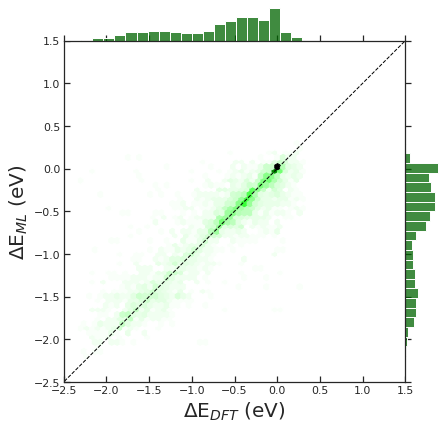

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="ticks")

#fig,ax = plt.subplots(figsize=(30,15))
x=y_test
y=y_pred

colors = ["000000"]
sns.set_palette(sns.color_palette(colors))

sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
joint_kws=dict(gridsize=40)
#ax.plot([-3,3],[-3,3])
a=sns.jointplot(x, y, kind="hex", color='darkgreen', xlim=(-2.5,1.5), ylim=(-2.5,1.5), 
                space=0, ratio=10,joint_kws= joint_kws, bins=70)


line=sns.lineplot(x=[-5,0,5],y=[-5,0,5],palette=colors,linewidth=1)
line.lines[0].set_linestyle("--")
#line.set(font_scale = 2)
a.ax_joint.set_xticks([-2.5,-2.0,-1.5,-1,-0.5,0,0.5,1,1.5])
a.ax_joint.set_yticks([-2.5,-2.0,-1.5,-1,-0.5,0,0.5,1,1.5])
a.set_axis_labels('$\Delta$E$_{DFT}$ (eV)','$\Delta$E$_{ML}$ (eV)',size=20)

# Import unique active motif from dataset & Search good element combination

## - From dataset, unique active motif of structuremade by our method can be enumerated. In this example, we only consider bimetalic catalyst. 

## - With various combinations of elements on the unqiue active motifs, it is possible to predict which element combinations wiil have optimal surface. 

In [6]:
from itertools import permutations

# screening bimetlaic surface from dataset 
bimetal_data = []
for datum in data:
    if len(datum['atoms']['chemical_symbols']) == 4: # 3 for H, 4 for CO
        bimetal_data.append(datum['mpid']+'_'+str(datum['mongo_id']))
        
atom_list = []
for name in bimetal_data:
    atom_list.append(read(path+name+'.traj'))
    
# get active motif of bimetalic surface and make list
active_motif_dict_list = []
for atoms in atom_list:
    active_motif_dict_list.append(get_unique_active_motif(atoms))
    
# Elements list to make element combinations
elements = ['Cu','Al','Si','Pd','Au','Pt','Ga','Sn','In','Ni','Se','Zn','Ge','As','Sb','Fe','V','Rh',
           'Ir','Ag','Co','Re','W','Ti','Pb','Os','Mo','Mn','Ru','Cr'] # Top 30 Metal in dataset 
combi_elements = list(permutations(elements,2)) # generate all combination containing two elements

# list for collect predicted energies dataframe
target_predict_dataframe_list =[] 

# lists for creating heatmap
first_atom_list = []
second_atom_list = []
density_list =[]


# make dataframe with active motif and predicted energy 
for combi in combi_elements: 
    #get fingerprint from active motif consisted with certain elements combination
    # error contain active motifs occuring error
    properties, error = active_motif_to_fingerprint(active_motif_dict_list,combi)
    df = pd.DataFrame({'name' : list(bimetal_data)},columns=['name'])
    
    column_name_list = ['active','floor','down']
    for column_name, i in zip(column_name_list,range(0,3)):
        df[column_name+'_number'] = properties[0][i]
        df[column_name+'_block'] = properties[1][i]
        df[column_name+'_radi'] = properties[2][i]
        df[column_name+'_oxi'] = properties[3][i]
        df[column_name+'_X'] = properties[4][i]
        df[column_name+'_row'] = properties[5][i]
        df[column_name+'_group'] = properties[6][i]
        df[column_name+'_thermal'] = properties[7][i]
        df[column_name+'_bp'] =properties[8][i]
        df[column_name+'_mp'] = properties[9][i]
        df[column_name+'_IE'] = properties[10][i]
        df[column_name+'_natom'] = properties[11][i]

    predict_X = df.iloc[:,1:] 
    predict_X = scalar.fit_transform(predict_X.astype(np.float64))
    CO_predict_y = regressor.predict(predict_X) # predict energies from active motif using trained model 
    energy_df = pd.DataFrame({'name' : df['name'],'CO_energy':CO_predict_y},
                                 columns=['name','CO_energy']) 
    
    # target_predict_dataframe_list contains dataframe of predcited energies from certain elements combination,   
    target_predict_dataframe_list.append(energy_df)

    # collect optimum surface density to create heatmap
    good_config = []
    for i,v in energy_df.iterrows():
        if (v['CO_energy'] >= -0.77) & (v['CO_energy'] <= -0.57):
            good_config.append(v['name'])
        density = len(good_config)/len(energy_df)
    
    first_atom_list.append(combi[0])
    second_atom_list.append(combi[1])
    density_list.append(density)
 

NameError: name 'data' is not defined

# Visualize predicted optimum surface density of bimetallic catalyst by heatmap

In [ ]:
# generate dataframe for heatmap
heatmap_df = pd.DataFrame({'First':first_atom_list,'Second':second_atom_list,
                           'density':density_list},columns=['First','Second','density'])
pivot_df = heatmap_df.pivot('First','Second','density')

# make heatmap
plt.rcParams['figure.figsize'] = [20, 16]

fig, ax = plt.subplots()
heatmap = ax.pcolor(pivot_df, cmap=plt.cm.viridis_r, edgecolors='k', linewidths=2)

ax.set_xticks(np.arange(0.5, len(pivot_df.columns), 1))
ax.set_xticklabels(pivot_df.columns,size=21)
ax.xaxis.tick_top()
#ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(pivot_df.index), 1))
ax.set_yticklabels(pivot_df.index,size=21)
#plt.clim(0,1)
cbar= plt.colorbar(heatmap)
heatmap.set_clim(0.0,0.3)
cbar.ax.tick_params(labelsize=25)